In [ ]:
import os
from tokenize import group
import numpy as np
import pandas as pd
import time
from math import radians, degrees, sin, cos, asin, acos, sqrt, atan2
from typing import List, Optional, Union, Tuple, Dict
from tqdm import tqdm
import xarray as xr

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable 
import matplotlib.ticker as mticker
from matplotlib.font_manager import FontProperties
import matplotlib.font_manager as fm
import matplotlib.lines as mlines
import tcmarkers

import pickle  

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from sklearn.decomposition import PCA

from scipy.ndimage import uniform_filter

from datetime import datetime, timedelta

# import haversine
from haversine import haversine

import tropycal.tracks as tracks

from numba import jit, prange, njit
from joblib import Parallel, delayed

import itertools    

# from ty_pkg import latlon
from ty_pkg import truncate_colormap, colorline, setup_map, weather_map_contour, contourf_and_save, ep_t, concentric_circles, interpolate_data, set_map
from ty_pkg import latlon_extent, storm_info, haversine_distance, Met, calculate_bearing_position, tc_finder, WindFieldSolver, find_large_groups, weighted_sum

# from metpy import potential_vorticity_baroclinic as pv_bc
from metpy.units import units
from metpy.calc import potential_temperature, lat_lon_grid_deltas
from metpy.calc import potential_vorticity_baroclinic as pv_bc

from dask import delayed, compute
from dask.diagnostics import ProgressBar

# pangu_dir = r'/home1/jek/Pangu-Weather'
pangu_dir = r'/data03/Pangu_TC_ENS'

pres_list = ['1000','925','850','700','600','500','400','300','250','200','150','100','50']
pres_array = np.array(pres_list, dtype=np.float32)

surface_factor = ['MSLP', 'U10', 'V10', 'T2M']
surface_dict = {'MSLP':0, 'U10':1, 'V10':2, 'T2M':3}
upper_factor = ['z', 'q', 't', 'u', 'v']
upper_dict = {'z':0, 'q':1, 't':2, 'u':3, 'v':4}

proj = ccrs.PlateCarree()
norm_p = mcolors.Normalize(vmin=950, vmax=1020)

# Define the colors you want in your colormap
colors = ["purple", "darkblue", "lightblue", "white", "yellow", "red", "pink"]

# Create a colormap from the colors
pwp = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

# <span style ="background:yellow; color:blue; font-weight:bold">**Functions: Bring ENS Data & Cov/Var Calculation**</span>

In [528]:
# --- REVISED calculate_potential_vorticity function ---
def calculate_potential_vorticity(temperature, pressure, u_wind, v_wind, lat_grid, lon_grid):
    """
    Calculate potential vorticity using MetPy's baroclinic potential vorticity function.

    Parameters:
    - temperature: Temperature (NumPy array)
    - pressure: Pressure (NumPy array)
    - u_wind: Zonal wind component (NumPy array)
    - v_wind: Meridional wind component (NumPy array)
    - lat_grid: 2D Latitude grid (NumPy array, degrees)
    - lon_grid: 2D Longitude grid (NumPy array, degrees)

    Returns:
    - Potential vorticity (pint.Quantity)
    """
    # 1. Convert all inputs to pint.Quantity with correct units
    temperature_q = temperature * units.K
    pressure_q = (pressure * units.hPa).to(units.Pa) # Convert hPa to Pa
    u_wind_q = u_wind * units.m / units.s
    v_wind_q = v_wind * units.m / units.s
    lat_grid_q = lat_grid * units.degrees
    lon_grid_q = lon_grid * units.degrees

    # 2. Calculate potential temperature (theta)
    theta = potential_temperature(pressure_q, temperature_q)

    # 3. Calculate dx and dy from the 2D lat/lon grids
    dx_grid_2d, dy_grid_2d = lat_lon_grid_deltas(lon_grid_q, lat_grid_q)

    # --- REVISED: Expand dx_grid and dy_grid to 3D ---
    # Assuming the 3D data shape is (level, latitude, longitude)
    # Add a new axis at the beginning (for the level dimension)
    dx_grid = dx_grid_2d[np.newaxis, :, :]
    dy_grid = dy_grid_2d[np.newaxis, :, :]

    # To ensure broadcasting works correctly, make sure dx_grid and dy_grid
    # have the same number of levels as your input data.
    # You can broadcast them explicitly to the shape of your 3D data,
    # or MetPy's internal broadcasting might handle it if the newaxis is correct.
    # Let's explicitly broadcast for clarity and robustness:
    num_levels = temperature_q.shape[0] # Assuming level is the first dimension
    dx_grid = np.broadcast_to(dx_grid, (temperature_q.shape[0], *dx_grid_2d.shape))
    dy_grid = np.broadcast_to(dy_grid, (temperature_q.shape[0], *dy_grid_2d.shape))
    # ---------------------------------------------------

    # 4. Calculate potential vorticity
    pv = pv_bc(
        potential_temperature=theta,
        pressure=pressure_q,
        u=u_wind_q,
        v=v_wind_q,
        dx=dx_grid, # Use the 3D dx_grid
        dy=dy_grid, # Use the 3D dy_grid
        latitude=lat_grid_q, # Latitude is used for Coriolis, can remain 2D or 3D
        # --- ADDED: Explicitly define the dimension indices ---
        # Assuming your 3D data is (level, latitude, longitude)
        vertical_dim=0, # Index for level dimension
        y_dim=1,        # Index for latitude dimension
        x_dim=2         # Index for longitude dimension
        # ---------------------------------------------------
    )

    return pv


# Bring data from ensemble members
def process_ens(input_data_dir: str, ens: Union[str, int], predict_interval: str,
                pres_array: np.ndarray = pres_array, lon_grid: np.ndarray = None, lat_grid: np.ndarray = None,
                level: Union[int, float, list, np.ndarray] = 850) -> Tuple[np.ndarray, np.ndarray]:
    upper = np.load(os.path.join(
        f'{input_data_dir}/{ens}/upper/{predict_interval}h.npy',
    )).astype(np.float32)
    # z, q 값 단위 변환
    upper[upper_dict['z']] /= 9.80665
    upper[upper_dict['q']] *= 1000

    # 레벨별 변수 추출
    if isinstance(level, (int, float)):
        level = [level]
    level = np.array(level, dtype=np.float32)
    level_idx = [np.where(pres_array == lv)[0][0] for lv in level]
    upper_part_level = upper[:, level_idx, :, :]  # Extract variables at requested levels


    # q 적분
    q_all = upper[upper_dict['q'], :]
    q_col = np.trapz(q_all[::-1], x=pres_array[::-1], axis=0)/9.80665/10  # 압력방향 뒤집기(보통 [높은압력, ..., 낮은압력]으로 적분)


    pv = calculate_potential_vorticity(
    temperature=upper[upper_dict['t']],
    pressure=np.broadcast_to(pres_array[:, np.newaxis, np.newaxis], upper[upper_dict['t']].shape),
    u_wind=upper[upper_dict['u']],
    v_wind=upper[upper_dict['v']],
    lat_grid=lat_grid,
    lon_grid=lon_grid
    )

    return upper_part_level, q_col, pv


# Compute variance vector for flattened distances
@njit(parallel=True)
def var_axis0(arr):
    N, M = arr.shape
    out = np.zeros(M)
    for j in prange(M):
        mean = np.mean(arr[:, j])
        acc = 0.0
        for i in range(N):
            acc += (arr[i, j] - mean) ** 2
        out[j] = acc / (N - 1)  # ddof=1
    return out

# Compute mean vector for flattened distances
@njit(parallel=True)
def mean_axis0(arr):
    N, M = arr.shape
    out = np.zeros(M)
    for j in prange(M):
        acc = 0.0
        for i in range(N):
            acc += arr[i, j]
        out[j] = acc / N
    return out

# Compute covariance vector for flattened distances and S matrix
@njit(parallel=True)
def compute_cov_vector(distances: np.ndarray, S: np.ndarray) -> np.ndarray:  # distances: (N,), S: (N, M)
    N, M = S.shape
    cov_vector = np.zeros(M)
    mean_d = 0.0
    for i in range(N):
        mean_d += distances[i]
    mean_d /= N

    for j in prange(M):  # 여기만 prange!
        mean_s = 0.0
        for i in range(N):
            mean_s += S[i, j]
        mean_s /= N

        cov = 0.0
        for i in range(N):
            cov += (distances[i] - mean_d) * (S[i, j] - mean_s)
        cov_vector[j] = cov / (N - 1)
    
    return cov_vector

#! Compute covariance/variance matrix for the given data and distances
def compute_cov_var(x_array: np.ndarray, distances_tar: np.ndarray, ens_idx_list: List[int]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute cov/var matrix for the given data and distances.
    
    Parameters:
    - x_array: Data array of shape (N, lat, lon)
    - distances_tar: Distances array of shape (N,)
    - ens_idx_list: List of ensemble indices
    
    Returns:
    - cov_var: Covariance/variance matrix of shape (lat, lon)
    """
    # Normalize x_array
    var_x_array = var_axis0(x_array.reshape(len(ens_idx_list), -1))
    var_x_array = var_x_array.reshape(x_array.shape[1], x_array.shape[2])
    mean_x_array = mean_axis0(x_array.reshape(len(ens_idx_list), -1))
    mean_x_array = mean_x_array.reshape(x_array.shape[1], x_array.shape[2])
    x_array = (x_array - mean_x_array)/np.sqrt(var_x_array)

    # Compute covariance vector, variance of x_array == 1
    cov_vector = compute_cov_vector(distances_tar, x_array.reshape(len(ens_idx_list), -1))
    cov_matrix = cov_vector.reshape(x_array.shape[1], x_array.shape[2])
    cov_var = np.array(cov_matrix)
    return cov_var

def map_gridlines(ax, proj = ccrs.PlateCarree(), font_size = 15, gridline_spaces = 10, zorder = 0):
    gl = ax.gridlines(crs=proj, draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--', zorder= zorder)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': font_size}
    gl.ylabel_style = {'size': font_size}
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, gridline_spaces))
    gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, gridline_spaces))


### Check whether PV is computed correctly

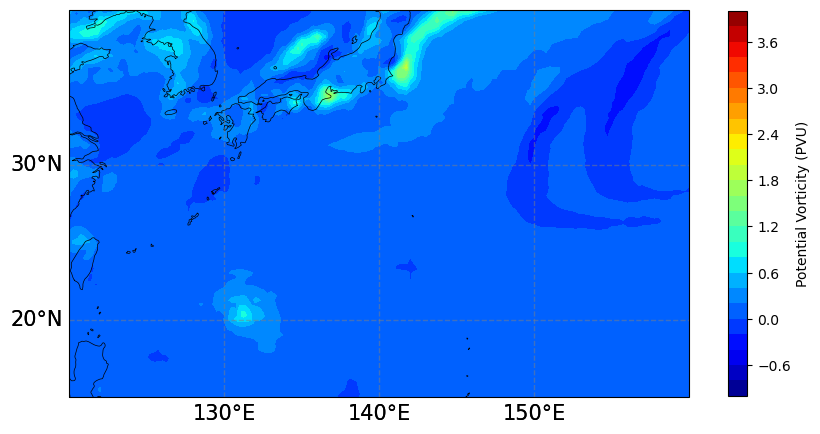

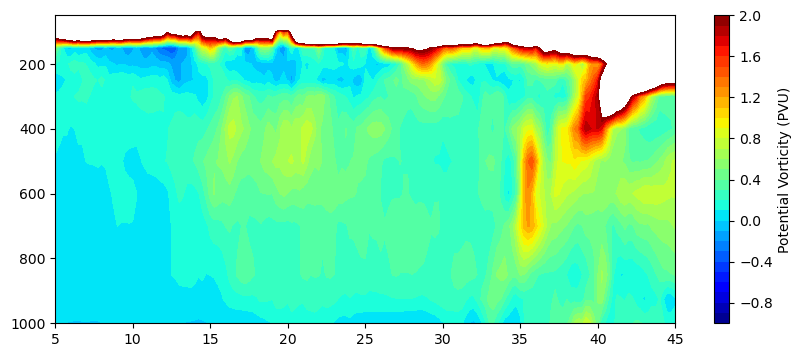

In [555]:
# --- REVISED calculate_potential_vorticity function ---
def calculate_potential_vorticity(temperature, pressure, u_wind, v_wind, lat_grid, lon_grid):
    """
    Calculate potential vorticity using MetPy's baroclinic potential vorticity function.

    Parameters:
    - temperature: Temperature (NumPy array)
    - pressure: Pressure (NumPy array)
    - u_wind: Zonal wind component (NumPy array)
    - v_wind: Meridional wind component (NumPy array)
    - lat_grid: 2D Latitude grid (NumPy array, degrees)
    - lon_grid: 2D Longitude grid (NumPy array, degrees)

    Returns:
    - Potential vorticity (pint.Quantity)
    """
    # 1. Convert all inputs to pint.Quantity with correct units
    temperature_q = temperature * units.K
    pressure_q = (pressure * units.hPa).to(units.Pa) # Convert hPa to Pa
    u_wind_q = u_wind * units.m / units.s
    v_wind_q = v_wind * units.m / units.s
    lat_grid_q = lat_grid * units.degrees
    lon_grid_q = lon_grid * units.degrees

    # 2. Calculate potential temperature (theta)
    theta = potential_temperature(pressure_q, temperature_q)

    # 3. Calculate dx and dy from the 2D lat/lon grids
    dx_grid_2d, dy_grid_2d = lat_lon_grid_deltas(lon_grid_q, lat_grid_q)

    # --- REVISED: Expand dx_grid and dy_grid to 3D ---
    # Assuming the 3D data shape is (level, latitude, longitude)
    # Add a new axis at the beginning (for the level dimension)
    dx_grid = dx_grid_2d[np.newaxis, :, :]
    dy_grid = dy_grid_2d[np.newaxis, :, :]

    # To ensure broadcasting works correctly, make sure dx_grid and dy_grid
    # have the same number of levels as your input data.
    # You can broadcast them explicitly to the shape of your 3D data,
    # or MetPy's internal broadcasting might handle it if the newaxis is correct.
    # Let's explicitly broadcast for clarity and robustness:
    num_levels = temperature_q.shape[0] # Assuming level is the first dimension
    dx_grid = np.broadcast_to(dx_grid, (temperature_q.shape[0], *dx_grid_2d.shape))
    dy_grid = np.broadcast_to(dy_grid, (temperature_q.shape[0], *dy_grid_2d.shape))
    # ---------------------------------------------------

    # 4. Calculate potential vorticity
    pv = pv_bc(
        potential_temperature=theta,
        pressure=pressure_q,
        u=u_wind_q,
        v=v_wind_q,
        dx=dx_grid, # Use the 3D dx_grid
        dy=dy_grid, # Use the 3D dy_grid
        latitude=lat_grid_q, # Latitude is used for Coriolis, can remain 2D or 3D
        # --- ADDED: Explicitly define the dimension indices ---
        # Assuming your 3D data is (level, latitude, longitude)
        vertical_dim=0, # Index for level dimension
        y_dim=1,        # Index for latitude dimension
        x_dim=2         # Index for longitude dimension
        # ---------------------------------------------------
    )

    return pv

ens = 470
# (224, 470)
predict_interval = '108'
upper = np.load(os.path.join(
    f'{input_data_dir}/{ens}/upper/{predict_interval}h.npy',
)).astype(np.float32)
# z, q 값 단위 변환
upper[upper_dict['z']] /= 9.80665
upper[upper_dict['q']] *= 1000


pv = calculate_potential_vorticity(
temperature=upper[upper_dict['t']],
pressure=np.broadcast_to(pres_array[:, np.newaxis, np.newaxis], upper[upper_dict['t']].shape),
u_wind=upper[upper_dict['u']],
v_wind=upper[upper_dict['v']],
lat_grid=lat_grid,
lon_grid=lon_grid
)

# pres_pres = np.meshgrid(pres_array, lat_grid[:,0])

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': proj})
ax.set_extent([120,160, 15,40], crs=proj)
map_gridlines(ax, proj=proj, font_size=15, gridline_spaces=10)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
cax = ax.contourf(lon_grid, lat_grid, pv[pres_list.index(str(1000)), :, :].magnitude*1e06, cmap='jet', transform=proj, levels=np.linspace(-1,4,26))
plt.colorbar(cax, ax=ax, orientation='vertical', pad=0.05, label='Potential Vorticity (PVU)', shrink=0.5)
map_gridlines(ax, proj=proj, font_size=15, gridline_spaces=10, zorder = 2)
plt.show()


pres_lat,lat_pres = np.meshgrid(pres_array, lat_grid[:,0])
fig = plt.figure(figsize=(10, 4))
plt.contourf(lat_pres, pres_lat, pv[:, :, 112].magnitude.T*1e06, cmap='jet', levels=np.linspace(-1,2,31), extent = 'both')
plt.colorbar(label='Potential Vorticity (PVU)', orientation='vertical', pad=0.05)
plt.gca().invert_yaxis()
plt.show()

In [524]:
lon_grid

array([[100.  , 100.25, 100.5 , ..., 159.5 , 159.75, 160.  ],
       [100.  , 100.25, 100.5 , ..., 159.5 , 159.75, 160.  ],
       [100.  , 100.25, 100.5 , ..., 159.5 , 159.75, 160.  ],
       ...,
       [100.  , 100.25, 100.5 , ..., 159.5 , 159.75, 160.  ],
       [100.  , 100.25, 100.5 , ..., 159.5 , 159.75, 160.  ],
       [100.  , 100.25, 100.5 , ..., 159.5 , 159.75, 160.  ]])

<div style="
  display: flex;
  justify-content: center;
  align-items: center;
  background: radial-gradient(ellipse at center, #009cd9 0%, #01263a 100%);
">
  <div style="
    text-align: center;
    color: #fff;
    font-weight: bold;
    font-size: 3.5rem;
    padding: 32px 56px;
    border-radius: 40px;
    background: rgba(0,156,217,0.75);
    box-shadow: 0 8px 32px 0 rgba(0,40,80,0.35);
    letter-spacing: 0.05em;
    text-shadow: 
      0 4px 20px #0088b8,
      0 0 30px #3df2ff,
      0 0 8px #fff;
    position: relative;
    overflow: hidden;
  ">
    <span style="font-size: 2.7rem; margin-right: 0.5em; vertical-align: middle; animation:spin 2s linear infinite;">🌀</span>
    <span style="display: inline-block; vertical-align: middle;">
      Bring <span style="color: #ffe66b; filter: drop-shadow(0 0 12px #fffbe7);">TC data</span>
    </span>
    <span style="font-size: 2.7rem; margin-left: 0.5em; vertical-align: middle; animation:spinrev 2s linear infinite;">🌀</span>
    <div style="font-size: 1.2rem; margin-top: 18px; opacity: 0.8; letter-spacing: 0.04em;">
      <span style="font-size:1.6rem;">🌬️</span> Typhoon’s track <span style="font-size:1.6rem;">🌊</span>
    </div>
  </div>
</div>
<style>
@keyframes spin {
  0% {transform: rotate(0deg);}
  100% {transform: rotate(360deg);}
}
@keyframes spinrev {
  0% {transform: rotate(360deg);}
  100% {transform: rotate(0deg);}
}
</style>


# Bring TC data

In [362]:
#! 태풍 경로 정보 기존 정보 불러오기
#위경도 지정
lat_indices, lat_start, lat_end, lon_indices, lon_start, lon_end, extent, latlon_ratio = latlon_extent(100,160,5,45)  
lon_grid, lat_grid = np.meshgrid(lon_indices[lon_start:lon_end + 1], lat_indices[lat_start:lat_end + 1])


ssv_dict = {}


#태풍 지정
storm_name, storm_year, key_time_list  = 'HINNAMNOR', 2022, ['2022/08/27/00UTC']
# storm_name, storm_year, key_time_list  = 'NORU', 2017, ['2017/07/30/00UTC']
# storm_name, storm_year, key_time_list  = 'DEBBY', 2012, ['2012/06/23/00UTC']                                                                               


if storm_name == 'DEBBY':
    lat_indices, lat_start, lat_end, lon_indices, lon_start, lon_end, extent, latlon_ratio = latlon_extent(250,310,5,45)  
    lon_grid, lat_grid = np.meshgrid(lon_indices[lon_start:lon_end + 1], lat_indices[lat_start:lat_end + 1])


surface_factors = []  # 예시: 지표면에서는 'MSLP'만 선택
upper_factors = ['z'] 
if storm_name == 'HINNAMNOR':
    perturation_scale = 0.05
else:
    perturation_scale = 0.1

#예측 시간 지정, 초기 시간 지정, 앙상블 수
predict_interval_list = np.arange(0,24*7+1,6)  
ens_list = range(0,4000)
new_ssv = 'n'           #새로 생성할 것인지 여부, n이면 기존 파일 불러옴
retro_opt = 'td'        #다시 돌아가면서 태풍 추적시 강한 것만 추적하려면 td로

if retro_opt =='td':
    retro_opt = '_td'
else:
    retro_opt = ''
        
#! 태풍 경로 정보 새로 생성하기

for first_str in key_time_list:
    first_time = datetime.strptime(first_str, "%Y/%m/%d/%HUTC")
    key_str = first_time.strftime("%m.%d.%HUTC")
    ssv_key = first_time
    surface_factors.sort()
    upper_factors.sort()
    surface_str = "".join([f"_{factor}" for factor in surface_factors])  # 각 요소 앞에 _ 추가
    upper_str = "".join([f"_{factor}" for factor in upper_factors])  # 각 요소 앞에 _ 추가
    
    datetime_list = np.array([first_time + timedelta(hours=int(hours)) for hours in predict_interval_list])
    # datetime_array = np.array([(first_time + timedelta(hours=int(hours))) for hours in predict_interval_list])
    storm_lon, storm_lat, storm_mslp, storm_time = storm_info(pangu_dir, storm_name, storm_year, datetime_list = datetime_list, wind_thres=0)   #태풍 영문명, 년도 입력

    
    # with open(rf'/data03/Pangu_TC_ENS/{perturation_scale}ENS{surface_str}{upper_str}/ssv_dict{retro_opt}_{min(ens_list)}_{max(ens_list)}.pkl', 'rb') as f:
    with open(rf'{pangu_dir}/output_data/{first_str}/{perturation_scale}ENS{surface_str}{upper_str}/ssv_dict{retro_opt}_{min(ens_list)}_{max(ens_list)}.pkl', 'rb') as f:
        ssv_dict = pickle.load(f)



'''
ens_idx_list는 전체 4000개 멤버 중에서 key_time에 해당하는 멤버들에 대한 인덱스 리스트

이후에 ens_idx_list에서 group에 속하는 것들은 group_idx_all_list에 저장

group_idx_list는 ens_idx_list에서 해당하는 인덱스를 추출, ens_uv_factor_uv_all에서 group_idx_list로 인덱싱하여 ens_factor_uv를 구함
'''

if storm_name == 'HINNAMNOR':
    key_time = datetime(2022,8,27,0)             #처음 시점 지정
    start_time = datetime(2022,8,28,0)           #분석 시작 시점
    target_time = datetime(2022,8,31,0)           #위치 projection을 구하고자 하는 시간
elif storm_name == 'NORU':
    key_time = datetime(2017,7,30,0)              #처음 시점 지정
    start_time = datetime(2017,7,30,0)            #분석 시작 시점
    target_time = datetime(2017,8,4,0)            #위치 projection을 구하고자 하는 시간
elif storm_name == 'DEBBY':
    key_time = datetime(2012,6,23,0)              #처음 시점 지정
    start_time = datetime(2012,6,24,0)            #분석 시작 시점
    target_time = datetime(2012,6,27,0)            #위치 projection을 구하고자 하는 시간

key_str = key_time.strftime("%m.%d %HUTC")
start_str = start_time.strftime("%m.%d %HUTC")
target_str = target_time.strftime("%m.%d %HUTC")

total_time_range = int((target_time - key_time).total_seconds() / 3600)
start_time_range = int((start_time  - key_time).total_seconds() / 3600)

# 변수 지정
distance_threshold = 0                      #가까운 태풍의 거리
steer_pres = [850,700,600,500,400,300,250]  #steering wind 구할 때 사용하는 고도 바꿀 필요 x
axis_opt = 'quiver'                         #axis 뭘로 잡을지, opt: 위치 상관관계 최대인 axis, tar: 최종 위치의 axis, mid: 중간 위치의 axis, lon: 경도, lat: 위도
data_sign = 'y'                             #기존의 데이터를 사용할 것인지, n이면 새로 구함
time_array = np.arange(start_time_range,total_time_range+1,6)  #예측 시간 범위
if storm_name == 'NORU':
    time_array = np.arange(6, 121, 6)  #Noru는 6시간 단위로만 진행

nearby_sign_name = '_nearby'
altitude = '850_200'
choosen_factor = 'steering_wind'


## Draw Best and ENS Track ↕️

In [ ]:
ds = xr.open_dataset(rf'/home1/jek/Pangu-Weather/input_data/IBTrACS.WP.v04r01.nc')
hin_ds = ds.where((ds['season'] == storm_year) & (ds['name'] == b'HINNAMNOR'), drop=True)
storm_lat, storm_lon, storm_time, storm_speed, storm_type = hin_ds['usa_lat'][0].values.astype(np.float32), hin_ds['usa_lon'][0].values.astype(np.float32), hin_ds['iso_time'][0].values.astype('datetime64').astype(datetime), hin_ds['usa_wind'][0].values.astype(np.float32), hin_ds['nature'][0].values.astype('str')
storm_usa_type = hin_ds['usa_status'][0].values.astype('str')

storm_lat = storm_lat[(storm_lat != '') & (storm_lat != None)]
storm_lon = storm_lon[(storm_lon != '') & (storm_lon != None)]
storm_time = storm_time[(storm_time != '') & (storm_time != None)]
storm_speed = storm_speed[(storm_speed != '') & (storm_speed != None)]
storm_type = storm_type[(storm_type != '') & (storm_type != None)]
storm_usa_type = storm_usa_type[(storm_usa_type != '') & (storm_usa_type != None)]

color_dict = {'DB': 'cyan', 'TD': 'cyan', 'TS': 'green', 'TY': 'orange', 'ST': 'red', 'SSW': 'purple', 'EX': 'gray'}
type_colors = [color_dict[t] for t in storm_usa_type if t in color_dict]
# Define the order and mapping for your legend labels
legend_labels_order = {'TD': 'TD', 'TS': 'TS', 'TY': 'TY', 'ST': 'ST'}

# Tokyo lon, lat starts from -8/28 06 UTC

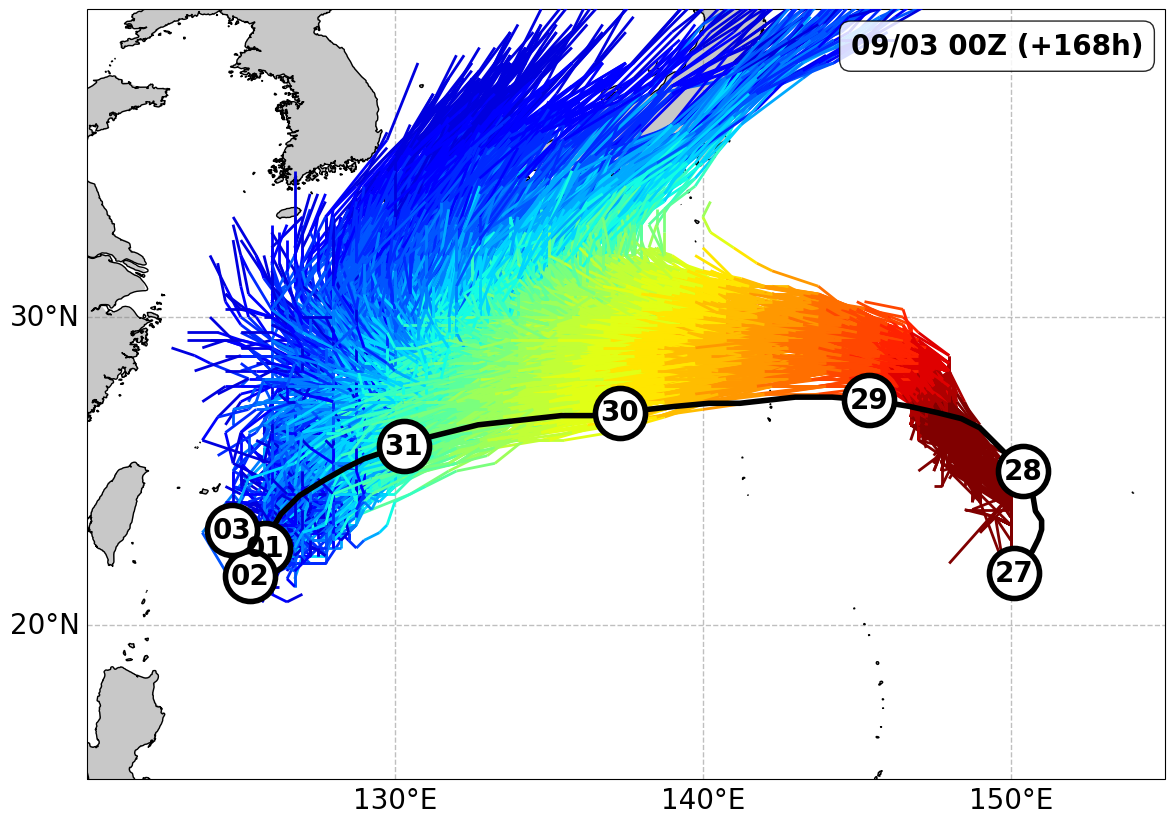

In [347]:
for predict_interval in range(168, 169, 12):
# storm_lon, storm_lat, storm_mslp, storm_time = storm_info(pangu_dir, storm_name, storm_year, datetime_list = None, wind_thres=0)   #태풍 영문명, 년도 입력
# storm_lon, storm_lat, storm_mslp, storm_time = storm_info(pangu_dir, storm_name, storm_year, datetime_list = datetime_list, wind_thres=0)   #태풍 영문명, 년도 입력
# for predict_interval in range(24, 25, 12):
    datetime1 = key_time + timedelta(hours=int(predict_interval))


            
    for key_time ,min_position in ssv_dict.items():
        fig, ax = plt.subplots(1, 1, figsize=(10*latlon_ratio, 10), subplot_kw={'projection': proj})
        key_str = key_time.strftime("%m.%d.%HUTC")
        ax.set_extent([120,155,15,40], crs=proj)
        # ax.set_extent([255,290,20,45], crs=proj)
        # ocean_color = mcolors.to_rgba((147/255, 206/255, 229/255))
        land_color = mcolors.to_rgba((200/255, 200/255, 200/255))
        ax.add_feature(cfeature.LAND, color=land_color, edgecolor='none')
        # ax.add_feature(cfeature.OCEAN, color=ocean_color)
        ax.coastlines(resolution='10m', color='black', linewidth=1)
        map_gridlines(ax, proj, font_size=20)

        ax.plot(storm_lon[:57], storm_lat[:57], color='black', linestyle='-', marker='', transform=ax.projection, zorder=10, linewidth=4)
        for i in range(len(storm_usa_type))[:57:2]:
            new_time = storm_time[i].strftime("%Y/%m/%d/%HUTC")
            if new_time.endswith('00UTC'):
                ax.scatter(storm_lon[i], storm_lat[i], color='w', transform=ax.projection, zorder=10, s=1300, edgecolors='black', linewidth=4)
                ax.text(storm_lon[i], storm_lat[i], new_time[8:-6]
                        , horizontalalignment='center', verticalalignment='center', fontsize=20, zorder = 20, fontweight = 'bold')



        for ens in ens_list:  
        # for ens in [0]:  
            # print(ens)

            pred_times = [pos for pos, _ in min_position[ens].items()]
            if datetime1 in pred_times:
                time_idx = pred_times.index(datetime1)
            elif any(key < datetime1 for key in min_position[ens].keys()):
                time_idx = -1
            else:
                continue
            lons = [pos['lon'] for _,pos in min_position[ens].items()][:time_idx]
            lats = [pos['lat'] for _,pos in min_position[ens].items()][:time_idx]
            min_values = [pos['mslp'] for _,pos in min_position[ens].items()][:time_idx]
            pred_times = [pos for pos, _ in min_position[ens].items()][:time_idx]
            z = np.array([(t - key_time).total_seconds() / 3600 for t in pred_times])
            # print(ens)
            if len(lons) < 1:
                continue
            # ax.plot(lons, lats, color='red', linestyle='-', marker='', transform=ax.projection, zorder=5, linewidth=4)
            # ax.scatter(lons[-1], lats[-1], color='red', s=400, transform=ax.projection, zorder=5, marker = tcmarkers.HU)
            lc = colorline(ax, lons, lats, z=z, cmap=plt.get_cmap('jet_r'), norm=mcolors.Normalize(vmin=24, vmax=168), linewidth=2, alpha=1, transform=ax.projection, zorder=5)

        # --- 오버레이 텍스트 생성 ---
        text_str = f"{datetime1.strftime('%m/%d %HZ')} (+{predict_interval}h)"

        # 오른쪽 위에 박스 스타일로 표시 (axes fraction 사용)
        ax.text(
            0.98, 0.97, text_str,             # x, y (axes 좌표: 1,1이 오른쪽 위)
            transform=ax.transAxes,
            ha='right', va='top',
            fontsize=20,
            fontweight='bold',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4', alpha=0.85),
            zorder=99,
        )
        fig.savefig(f'/home1/jek/Pangu-Weather/plot/{storm_name}_Ensemble_track_{predict_interval}h_lc.png',bbox_inches='tight')
        # plt.close(fig)
        plt.show()




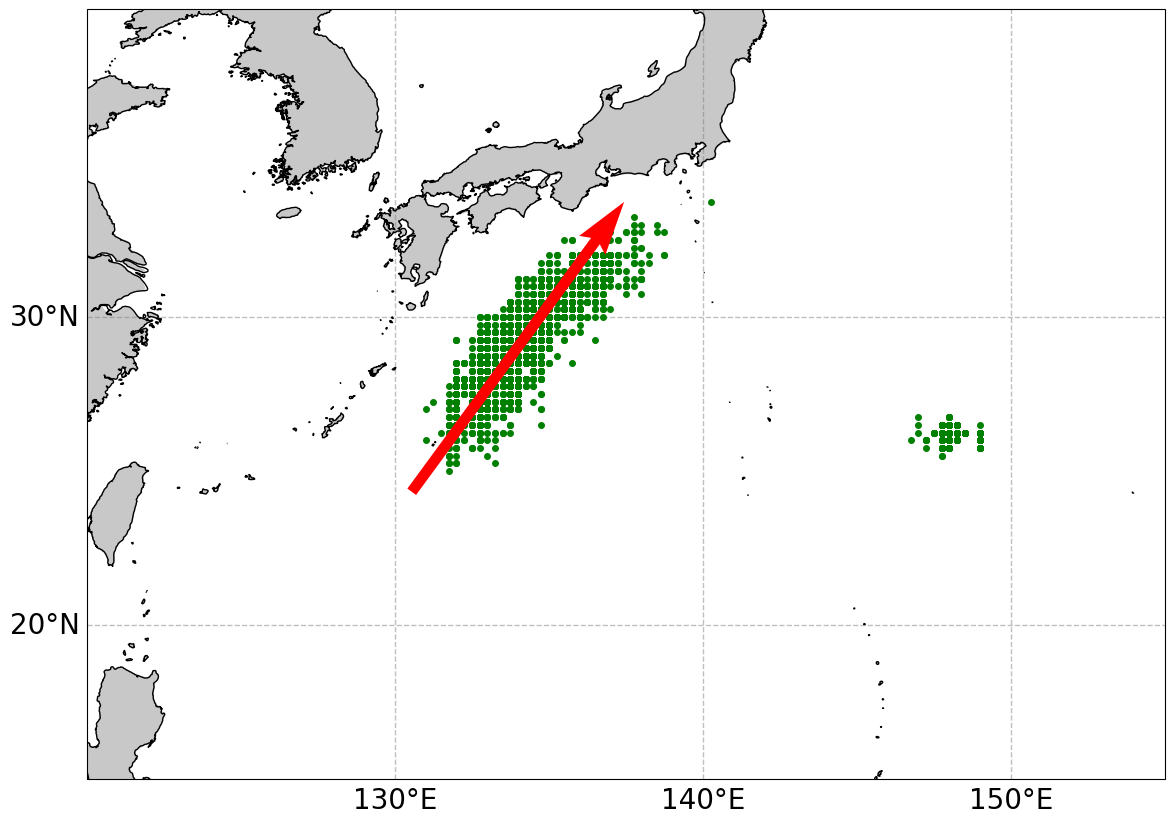

In [372]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import timedelta
import numpy as np

ens_idx_list = []
        
for ens in ens_list[:]:
    if (target_time in ssv_dict[key_time][ens]):
        ens_idx_list.append(ens)


# 데이터를 추출합니다
tar_pos = np.array([(ssv_dict[key_time][ens][target_time]['lon'], ssv_dict[key_time][ens][target_time]['lat']) for ens in ens_idx_list])

#타겟 위치의 PCA
corr_pos_tar = np.copy(tar_pos)
corr_pos_tar[:, 0] = (tar_pos[:, 0]-np.mean(tar_pos[:, 0])) * np.cos(np.radians(tar_pos[:, 1]))  # 경도에 cos(위도)를 곱해 거리 왜곡 보정
pca_tar = PCA(n_components=1)
pca_tar.fit(corr_pos_tar)
pca_tar.mean_[0] = pca_tar.mean_[0] / np.cos(np.radians(pca_tar.mean_[1])) + np.mean(tar_pos[:, 0])
ensemble_mean = np.mean(pca_tar.transform(corr_pos_tar)[:, 0])


for key_time ,min_position in ssv_dict.items():
    fig, ax = plt.subplots(1, 1, figsize=(10*latlon_ratio, 10), subplot_kw={'projection': proj})
    key_str = key_time.strftime("%m.%d.%HUTC")
    ax.set_extent([120,155,15,40], crs=proj)
    ax.add_feature(cfeature.LAND, color=mcolors.to_rgba((200/255, 200/255, 200/255)), edgecolor='none')
    ax.coastlines(resolution='10m', color='black', linewidth=1)
    map_gridlines(ax, proj, font_size=20)

    # ax.plot(storm_lon[:57], storm_lat[:57], color='black', linestyle='-', marker='', transform=ax.projection, zorder=10, linewidth=4)
    # for i in range(len(storm_usa_type))[:57:2]:
    #     new_time = storm_time[i].strftime("%Y/%m/%d/%HUTC")
    #     if new_time.endswith('00UTC'):
    #         ax.scatter(storm_lon[i], storm_lat[i], color='w', transform=ax.projection, zorder=10, s=1300, edgecolors='black', linewidth=4)
    #         ax.text(storm_lon[i], storm_lat[i], new_time[8:-6]
    #                 , horizontalalignment='center', verticalalignment='center', fontsize=20, zorder = 20, fontweight = 'bold')

    mean_lon_list = []
    mean_lat_list = []
    for predict_interval in [24, 96]:
        datetime1 = key_time + timedelta(hours=int(predict_interval))
        mean_lon = []
        mean_lat = []
        for ens in ens_list:
            pred_times = [pos for pos, _ in min_position[ens].items()]
            if datetime1 in pred_times:
                # Find the exact 00UTC prediction for this ensemble and predict_interval
                predicted_pos = min_position[ens].get(datetime1)
                if predicted_pos:
                    ax.plot(predicted_pos['lon'], predicted_pos['lat'],
                            marker='o', markersize=4, color='green',
                            linestyle='None', transform=ax.projection, zorder=10,
                            label=f'Ensemble {ens} 00UTC', alpha = 1) # Add a label for clarity
                    
                mean_lon.append(predicted_pos['lon'])
                mean_lat.append(predicted_pos['lat'])
                    
            elif any(key < datetime1 for key in min_position[ens].keys()):
                # If datetime1 is not an exact match but there are earlier predictions,
                # you might want to find the closest 00UTC prediction before datetime1
                # or just skip if you only want exact 00UTC for the predict_interval.
                # For this specific request, we'll only plot the exact predict_interval if it's 00UTC.
                pass
            else:
                continue

        # --- 오버레이 텍스트 생성 ---
        # text_str = f"{datetime1.strftime('%m/%d %HZ')} (+{predict_interval}h)"

        # # 오른쪽 위에 박스 스타일로 표시 (axes fraction 사용)
        # ax.text(
        #     0.98, 0.97, text_str,             # x, y (axes 좌표: 1,1이 오른쪽 위)
        #     transform=ax.transAxes,
        #     ha='right', va='top',
        #     fontsize=20,
        #     fontweight='bold',
        #     bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4', alpha=0.85),
        #     zorder=99,
        # )
        # fig.savefig(f'/home1/jek/Pangu-Weather/plot/{storm_name}_Ensemble_track_{predict_interval}h_lc.png',bbox_inches='tight')
        # plt.close(fig)
        mean_lon_list.append(np.mean(mean_lon))
        mean_lat_list.append(np.mean(mean_lat))
    # ax.plot(mean_lon_list, mean_lat_list, color='blue', linestyle='-', marker='', transform=ax.projection, zorder=5, alpha = 1, label='Mean Ensemble Track')
    ax.quiver(pca_tar.mean_[0]-pca_tar.components_[0, 0]*6, pca_tar.mean_[1]-pca_tar.components_[0, 1]*6, pca_tar.components_[0, 0], pca_tar.components_[0, 1] , scale=3, color='r', width=0.01, label='Principal Axis', zorder = 30)
    plt.show()

## Draw IBTRACS TRACK & Intensity

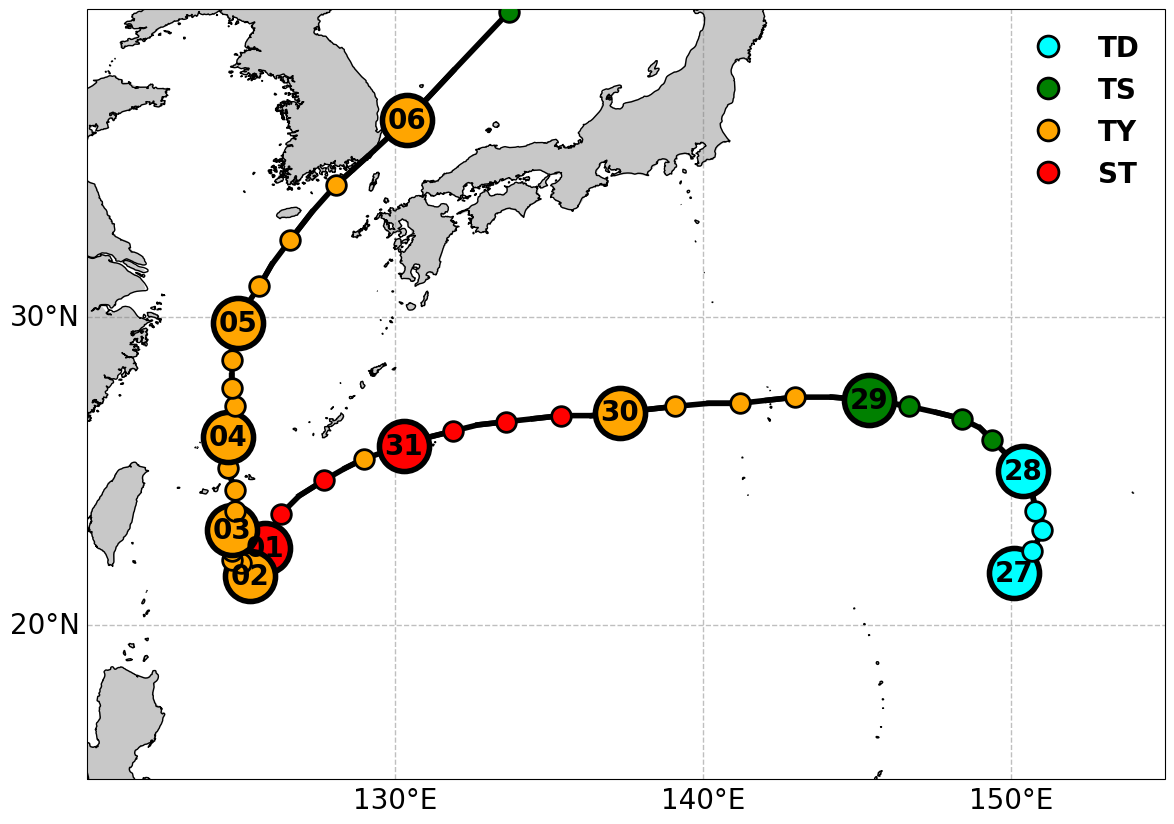

In [ ]:
fig, ax = plt.subplots(figsize=(10*latlon_ratio, 10), subplot_kw={'projection': proj})
ax.set_extent([120,155,15,40], crs=proj)
ax.add_feature(cfeature.LAND, color=mcolors.to_rgba((200/255, 200/255, 200/255)), edgecolor='none')
ax.coastlines(resolution='10m', color='black', linewidth=1)
map_gridlines(ax, proj, font_size=20)


legend_handles = []
# Keep track of which labels have already been added to avoid duplicates
added_labels = set()




for i in range(len(storm_usa_type))[::2]:
    current_type = storm_usa_type[i]
    if current_type in color_dict:
        # Plot the storm track with the corresponding color
        if storm_time[i] == datetime(2022, 8, 28, 0):
            current_type = 'TD'  # 태풍이 TD로 시작하는 경우
        ax.plot(storm_lon[i: i+4], storm_lat[i: i+4], color='black', linestyle='-', marker='', transform=ax.projection, zorder=10, linewidth=4)
        ax.scatter(storm_lon[i], storm_lat[i], color=color_dict[current_type], transform=ax.projection, zorder=10, s=200, edgecolors='black', linewidth=2)


        new_time = storm_time[i].strftime("%Y/%m/%d/%HUTC")
        if new_time.endswith('00UTC'):
            ax.scatter(storm_lon[i], storm_lat[i], color=color_dict[current_type], transform=ax.projection, zorder=10, s=1300, edgecolors='black', linewidth=4)
            dx, dy = 0, -0  # 시간 나타낼 위치 조정
            new_lon, new_lat = storm_lon[i] + dx, storm_lat[i] + dy
            
            # annotate를 사용하여 텍스트와 함께 선(화살표)을 그림
            ax.text(new_lon, new_lat, new_time[8:-6]
                    , horizontalalignment='center', verticalalignment='center', fontsize=20, zorder = 20, fontweight = 'bold')
        # Add to legend handles if it's one of the types you want to label and hasn't been added yet
        if current_type in legend_labels_order and current_type not in added_labels:
            label = legend_labels_order[current_type]
            color = color_dict[current_type]
            # Create a proxy artist for the legend
            legend_handle = mlines.Line2D([], [], color=color, marker='o', linestyle='None',
                                markersize=15, # Adjust marker size for the legend
                                markeredgecolor='black', # Match the edge color of your plotted points
                                markeredgewidth=2, # Match the edge width
                                label=label)
            legend_handles.append(legend_handle)
            added_labels.add(current_type)

# Add the legend to the plot
font_props = fm.FontProperties(size=20, weight='bold', family='Times New Roman')
ax.legend(handles=legend_handles, loc='upper right', frameon = False, prop=font_props)

# plt.title('Storm Tracks')
plt.show()

## GIF maker

In [348]:
import os
import re
from PIL import Image

# 이미지 폴더 경로
img_dir = r"/home1/jek/Pangu-Weather/plot"

# 이미지 확장자 목록 (원하는 형식 추가)
img_exts = ("h_lc.png")

# 파일명 오름차순 정렬
img_files = sorted([
    os.path.join(img_dir, f) 
    for f in os.listdir(img_dir)
    if (f.lower().endswith(img_exts))
])

def extract_hour(fname):
    match = re.search(r'_(\d+)h_', fname)
    return int(match.group(1)) if match else -1

img_files_sorted = sorted(img_files, key=extract_hour)

frames = []
# 예시로, 위 50픽셀, 아래 50픽셀, 왼쪽 30픽셀 잘라내기
for file in img_files_sorted[::]:
    img = Image.open(file)
    frames.append(img)

# GIF로 저장 (duration=각 프레임 밀리초)
frames[0].save(
    os.path.join(img_dir, f"{storm_name}_lc.gif"),
    save_all=True,
    append_images=frames[1:],
    duration=500,  # 0.1초당 한장 (원하면 수정)
    loop=0
)

print("GIF 저장 완료!")


GIF 저장 완료!


In [546]:
ens_idx_list[np.argmin(distances_tar)], ens_idx_list[np.argmax(distances_tar)]

(224, 470)

# <span style ="background:yellow; color:blue; font-weight:bold">**Calculate & Draw Sensitivity 🔢**</span>

In [ ]:


cov_var_dict = {}
mean_flow_500hPa = {}

for predict_interval in range(24, 25, 6):
    print(f'Processing {predict_interval} hours forecast...')
    datetime1 = key_time + timedelta(hours=int(predict_interval))
    
    ens_idx_list = []
    cov_var_dict[predict_interval] = {}
        
    for ens in ens_list[:]:
        if (target_time in ssv_dict[key_time][ens]):
            ens_idx_list.append(ens)
    
    
    # 데이터를 추출합니다
    tar_pos = np.array([(ssv_dict[key_time][ens][target_time]['lon'], ssv_dict[key_time][ens][target_time]['lat']) for ens in ens_idx_list])
    

    #타겟 위치의 PCA
    corr_pos_tar = np.copy(tar_pos)
    corr_pos_tar[:, 0] = (tar_pos[:, 0]-np.mean(tar_pos[:, 0])) * np.cos(np.radians(tar_pos[:, 1]))  # 경도에 cos(위도)를 곱해 거리 왜곡 보정
    pca_tar = PCA(n_components=1)
    pca_tar.fit(corr_pos_tar)
    pca_tar.mean_[0] = pca_tar.mean_[0] / np.cos(np.radians(pca_tar.mean_[1])) + np.mean(tar_pos[:, 0])
    ensemble_mean = np.mean(pca_tar.transform(corr_pos_tar)[:, 0])

    #distance 구하기
    corr_pos_tar = np.copy(tar_pos)
    corr_pos_tar[:, 0] = (tar_pos[:, 0]-np.mean(tar_pos[:, 0])) * np.cos(np.radians(tar_pos[:, 1]))  # 경도에 cos(위도)를 곱해 거리 왜곡 보정
    projection = pca_tar.transform(corr_pos_tar)[:, 0]  # 주축에 투영된 데이터 (1차원)
    distances_tar = (projection - ensemble_mean) * 111



    # (N, M, K) N: ensemble number, M: lon, K: lat
    level_list = pres_array
    input_data_dir = f'{pangu_dir}/output_data/{first_str}/{perturation_scale}ENS{surface_str}{upper_str}'


    delayed_results = [
        delayed(process_ens)(
            input_data_dir, ens, predict_interval, pres_array=pres_array, lon_grid = lon_grid, lat_grid = lat_grid ,level=level_list
        )
        for ens in ens_idx_list
    ]       

    with ProgressBar():
        results = compute(*delayed_results, scheduler='threads')
        print("Dask computation completed.")

    x_array_all = np.array([r[0] for r in results])
    q_col = np.array([r[1] for r in results])
    pv = np.array([r[2] for r in results])
    x_array_all = np.transpose(x_array_all, (1, 2, 0, 3, 4))  # (N_ens, N_var, N_level, lat, lon) -> (N_var, N_level, N_ens, lat, lon)
    pv_all = np.transpose(pv, (1, 0, 2, 3))  # (N_ens, N_level, lat, lon) -> (N_level, N_ens, lat, lon)

    del results
    
    #! Covariance/variance calculation of basic variables
    dask_results = {predict_interval: {}}
    for upper_variable_idx, upper_variable in enumerate(upper_factor):
        dask_results[predict_interval][upper_variable] = {}
        for pres_idx, pres in enumerate(level_list):
            # x_array_all에서 해당 변수와 압력 레벨에 맞는 numpy 배열을 가져옵니다.
            # compute_cov_var는 여전히 numpy 배열을 입력으로 받습니다.
            x_array = x_array_all[upper_variable_idx][pres_idx]

            # dask.delayed를 사용하여 compute_cov_var 호출을 지연시킵니다.
            # 각 호출은 독립적인 태스크가 됩니다.
            dask_task = delayed(compute_cov_var)(x_array, distances_tar, ens_idx_list)
            dask_results[predict_interval][upper_variable][pres] = dask_task

    # 모든 Dask 태스크를 계산합니다.
    # 이 시점에서 실제로 compute_cov_var가 병렬로 실행됩니다.
    # (기본적으로는 로컬 스케줄러가 사용되며, dask.distributed를 설정하면 분산 환경에서도 실행 가능)
    cov_var_dict = compute(dask_results)[0] # dask.compute는 튜플을 반환하므로 [0]으로 딕셔너리를 추출

    print("\n--- Computation Complete ---")

    #! Add divergence and vorticity calculations
    cov_var_dict[predict_interval]['div'] = {}
    cov_var_dict[predict_interval]['vort'] = {}
    cov_var_dict[predict_interval]['pv'] = {}
    mean_flow_500hPa[predict_interval] = {}
    for i, pres in enumerate(level_list):
        u_array = x_array_all[upper_dict['u'], i, :, :]
        v_array = x_array_all[upper_dict['v'], i, :, :]
        pv = pv_all[i, :, :, :]
        dx = 111000 * 0.25 * np.cos(np.radians(lat_grid))
        dy = -111000 * 0.25  # Lat_grid is reversed in y-direction

        u_dx = np.gradient(u_array, axis=2) / dx
        u_dy = np.gradient(u_array, axis=1) / dy
        v_dx = np.gradient(v_array, axis=2) / dx
        v_dy = np.gradient(v_array, axis=1) / dy

        div = u_dx + v_dy
        vort = v_dx - u_dy
        
        cov_var_dict[predict_interval]['div'][pres] = compute_cov_var(div, distances_tar, ens_idx_list)
        cov_var_dict[predict_interval]['vort'][pres] = compute_cov_var(vort, distances_tar, ens_idx_list)
        cov_var_dict[predict_interval]['pv'][pres] = compute_cov_var(pv, distances_tar, ens_idx_list)

        if pres == 500:
            mean_flow_500hPa[predict_interval]['u'] = np.mean(u_array, axis=0)
            mean_flow_500hPa[predict_interval]['v'] = np.mean(v_array, axis=0)

    #! Compute total precipitable water (TPW)
    cov_var_dict[predict_interval]['tpw'] = compute_cov_var(q_col, distances_tar, ens_idx_list)

    
    
    del x_array_all, x_array, q_col, pv, pv_all
    del u_dx, u_dy, v_dx, v_dy, div, vort


# pickle.dump(cov_var_dict, open(f'/data03/Pangu_TC_ENS/output_data/cov_var/cov_var_all_variable_{storm_name}.pkl', 'wb'))
# pickle.dump(mean_flow_500hPa, open(f'/data03/Pangu_TC_ENS/output_data/cov_var/mean_flow_500hPa_{storm_name}.pkl', 'wb'))

Processing 24 hours forecast...
[########################################] | 100% Completed | 115.41 s
Dask computation completed.

--- Computation Complete ---


## <span style = "color:Blue; background-color:White">Calculate variance</span>

In [55]:
var_dict = {}

for predict_interval in range(6, 25, 6):
    print(f'Processing {predict_interval} hours forecast...')
    datetime1 = key_time + timedelta(hours=int(predict_interval))
    
    ens_idx_list = []
    var_dict[predict_interval] = {}
        
    for ens in ens_list[:]:
        if (target_time in ssv_dict[key_time][ens]):
            ens_idx_list.append(ens)
    
    
    # 데이터를 추출합니다
    tar_pos = np.array([(ssv_dict[key_time][ens][target_time]['lon'], ssv_dict[key_time][ens][target_time]['lat']) for ens in ens_idx_list])

    #타겟 위치의 PCA
    corr_pos_tar = np.copy(tar_pos)
    corr_pos_tar[:, 0] = (tar_pos[:, 0]-np.mean(tar_pos[:, 0])) * np.cos(np.radians(tar_pos[:, 1]))  # 경도에 cos(위도)를 곱해 거리 왜곡 보정
    pca_tar = PCA(n_components=1)
    pca_tar.fit(corr_pos_tar)
    pca_tar.mean_[0] = pca_tar.mean_[0] / np.cos(np.radians(pca_tar.mean_[1])) + np.mean(tar_pos[:, 0])
    ensemble_mean = np.mean(pca_tar.transform(corr_pos_tar)[:, 0])

    #distance 구하기
    corr_pos_tar = np.copy(tar_pos)
    corr_pos_tar[:, 0] = (tar_pos[:, 0]-np.mean(tar_pos[:, 0])) * np.cos(np.radians(tar_pos[:, 1]))  # 경도에 cos(위도)를 곱해 거리 왜곡 보정
    projection = pca_tar.transform(corr_pos_tar)[:, 0]  # 주축에 투영된 데이터 (1차원)
    distances_tar = (projection - ensemble_mean) * 111

    # (N, M, K) N: ensemble number, M: lon, K: lat
    # level_list = [1000, 850, 500, 250]  # Specify the pressure levels you want to extract
    level_list = pres_array
    input_data_dir = f'{pangu_dir}/output_data/{first_str}/{perturation_scale}ENS{surface_str}{upper_str}'
    results = Parallel(n_jobs=16)(
        delayed(process_ens)(input_data_dir, ens, predict_interval, pres_array = pres_array, level = level_list)
        for ens in tqdm(ens_idx_list, desc=f"Processing {predict_interval}h ensembles")
    )               
    q_col = np.array([r[1] for r in results])

    del results
    # Compute total precipitable water (TPW)
    var_vector = var_axis0(q_col.reshape(len(ens_idx_list), -1))
    var_matrix = var_vector.reshape(q_col.shape[1], q_col.shape[2])
    var_dict[predict_interval]['tpw'] = np.array(var_matrix)

    del q_col


# pickle.dump(cov_var_dict, open(f'/data03/Pangu_TC_ENS/output_data/cov_var/cov_var_all_variable_{storm_name}.pkl', 'wb'))
# pickle.dump(mean_flow_500hPa, open(f'/data03/Pangu_TC_ENS/output_data/cov_var/mean_flow_500hPa_{storm_name}.pkl', 'wb'))

Processing 6 hours forecast...


Processing 6h ensembles:   0%|          | 0/3806 [00:00<?, ?it/s]

Processing 6h ensembles: 100%|██████████| 3806/3806 [01:17<00:00, 48.88it/s]


Processing 12 hours forecast...


Processing 12h ensembles: 100%|██████████| 3806/3806 [01:19<00:00, 47.87it/s]


Processing 18 hours forecast...


Processing 18h ensembles: 100%|██████████| 3806/3806 [01:12<00:00, 52.22it/s]


Processing 24 hours forecast...


Processing 24h ensembles: 100%|██████████| 3806/3806 [00:57<00:00, 65.68it/s] 


## <span style ="background:White; color:black; font-weight:bold">**Draw Sensitivity 🖼️**</span>

### Bring cov_var data

In [ ]:
#! Bring data
# with open(f'/data03/Pangu_TC_ENS/output_data/cov_var/cov_var_all_variable_{storm_name}.pkl', 'rb') as f:
#     cov_var_dict = pickle.load(f)

# with open(f'/data03/Pangu_TC_ENS/output_data/cov_var/mean_flow_500hPa_{storm_name}.pkl', 'rb') as f:
#     mean_flow_500hPa = pickle.load(f)

Plotting pv at 400hPa for 24h forecast...


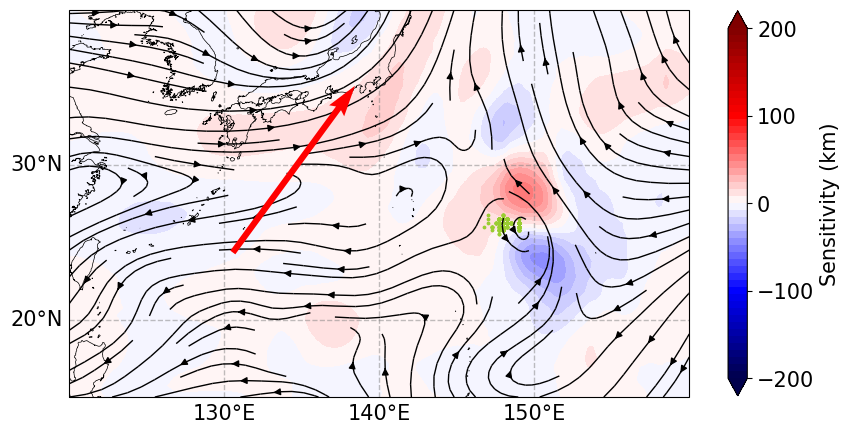

Plotting tpw for 24h forecast...
max: 102.11139709452125, min: -120.08652393250895
Maximum value at: 28, 150 with value: 70.54350807287258


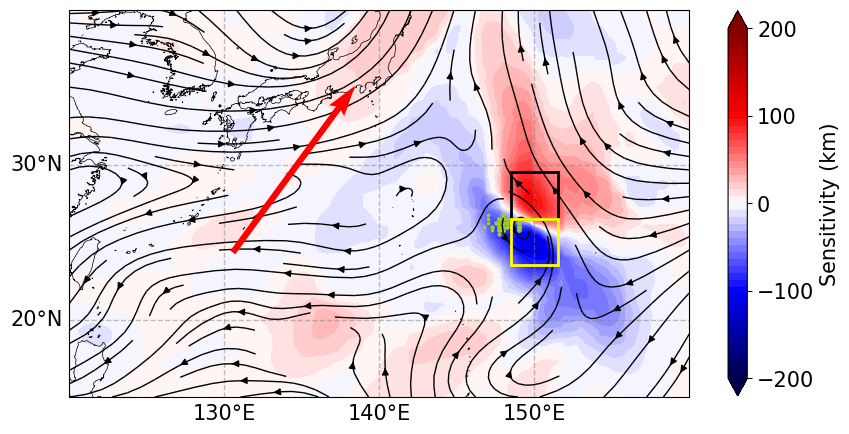

Plotting sensitive wind at 850hPa for 24h forecast...
max: 163.69221158091497


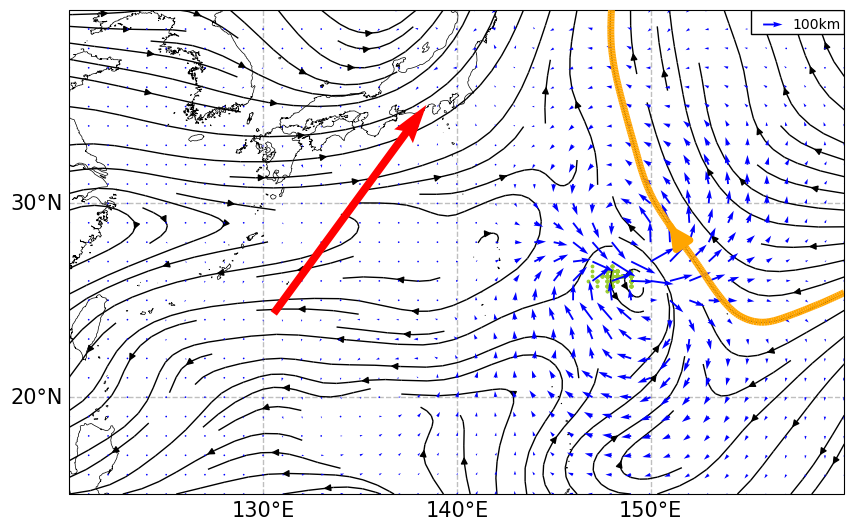

Plotting sensitive wind at 500hPa for 24h forecast...
max: 126.52583998052701


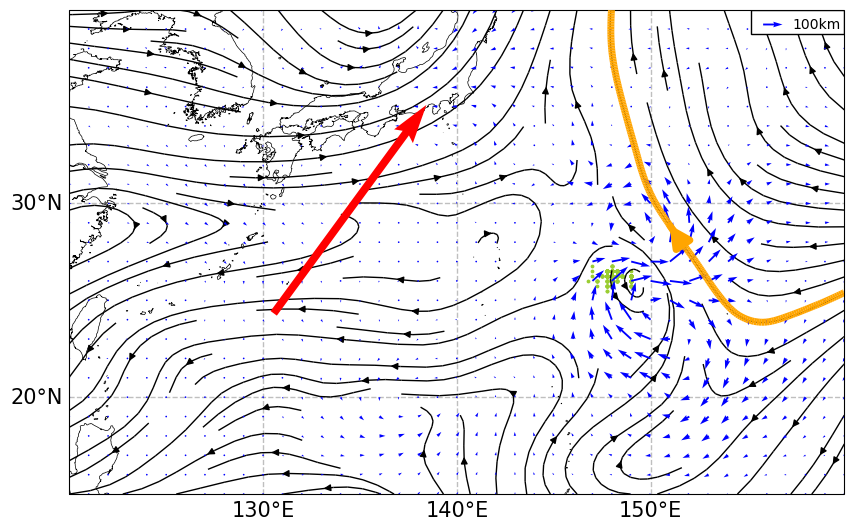

Plotting sensitive wind at 250hPa for 24h forecast...
max: 113.2406415404664


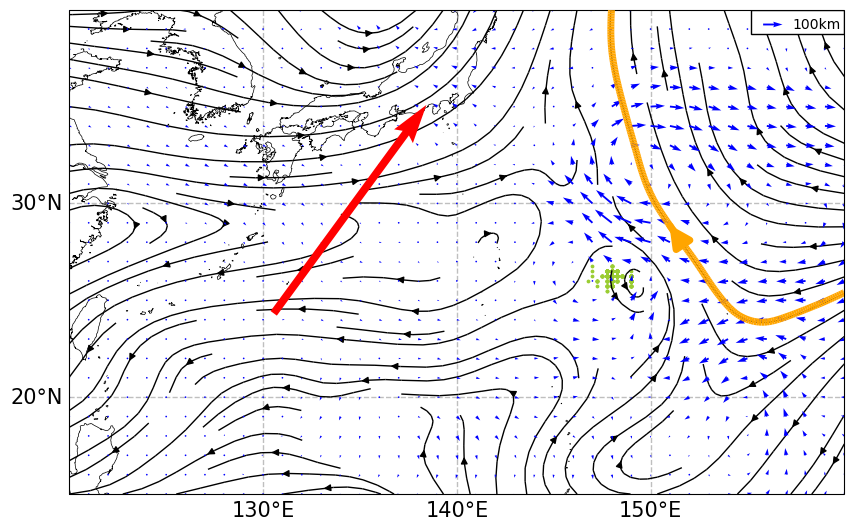

In [560]:


step = 4
quiver_scale = 100
sensitivity_scale = 200
extent = [120, 160, 15, 40]  
window = 13

# for predict_interval in cov_var_dict:
for predict_interval in [24]:
    datetime1 = key_time + timedelta(hours=int(predict_interval))
    
    wind_speed = np.sqrt(mean_flow_500hPa[predict_interval]['u']**2+mean_flow_500hPa[predict_interval]['v']**2)
    masked_u = np.where(wind_speed < 0.5, np.nan, mean_flow_500hPa[predict_interval]['u'])
    masked_v = np.where(wind_speed < 0.5, np.nan, mean_flow_500hPa[predict_interval]['v'])
    
    
    mid_ens_idx_list = []
    for ens in ens_list:
        if datetime1 in ssv_dict[key_time][ens]:
            mid_ens_idx_list.append(ens)

        # 데이터를 추출합니다
        mid_pos = np.array([(ssv_dict[key_time][ens][datetime1]['lon'], ssv_dict[key_time][ens][datetime1]['lat']) for ens in mid_ens_idx_list])

    for upper_variable in cov_var_dict[predict_interval]:
        if upper_variable in ['tpw']:
            print(f"Plotting {upper_variable} for {predict_interval}h forecast...")
            cov_var = cov_var_dict[predict_interval][upper_variable]
            print(f"max: {np.max(cov_var)}, min: {np.min(cov_var)}")
            # Plotting the covariance/variance
            fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': proj})
            ax.set_extent(extent, crs=proj)
            ax.coastlines('10m', linewidth=0.5)
            ax.streamplot(lon_grid, lat_grid, masked_u, masked_v, color='black', linewidth=1, transform=proj, density=1)
            sax = ax.contourf(
                lon_grid, lat_grid, cov_var, cmap='seismic',
                transform=proj, levels=np.linspace(-sensitivity_scale, sensitivity_scale, 51),
                extend='both', zorder=-1
            )
            sax_cb = plt.colorbar(sax, ax=ax, orientation='vertical', label='Sensitivity (km)', shrink=0.5)
            sax_cb.set_label('Sensitivity (km)', fontsize=15)  # colorbar 자체의 label
            sax_cb.ax.tick_params(labelsize=15)
            sax_cb.ax.set_yticks(np.linspace(-sensitivity_scale, sensitivity_scale, 5))
            # ax.quiver(pca_tar.mean_[0]+pca_tar.components_[0, 0]*6, pca_tar.mean_[1]+pca_tar.components_[0, 1]*6, -pca_tar.components_[0, 0], -pca_tar.components_[0, 1] , scale=3, color='r', width=0.01, label='Principal Axis', zorder = 30)
            ax.quiver(pca_tar.mean_[0]-pca_tar.components_[0, 0]*6, pca_tar.mean_[1]-pca_tar.components_[0, 1]*6, pca_tar.components_[0, 0], pca_tar.components_[0, 1] , scale=3, color='r', width=0.01, label='Principal Axis', zorder = 30)
            # ax.quiver(pca_tar.mean_[0], pca_tar.mean_[1], -pca_tar.components_[0, 0], -pca_tar.components_[0, 1] , scale=20, color='r', width=0.005, label='Principal Axis', zorder = 2)
            plt.scatter(mid_pos[:, 0], mid_pos[:, 1], c='yellowgreen', s=3, transform=proj)
            map_gridlines(ax, proj=proj)

           
            mean_map = uniform_filter(cov_var, size=window, mode='constant')  # 가장자리는 0-padding

            # 최대값 위치
            max_idx = np.unravel_index(np.argmax(mean_map), mean_map.shape)
            lat0, lon0 = lat_grid[max_idx[0], max_idx[1]], lon_grid[max_idx[0], max_idx[1]]  
            lat0, lon0 = 28, 150 
            print(f"Maximum value at: {lat0}, {lon0} with value: {mean_map[max_idx]}")
            

            # Rectangle: (x, y), width, height
            rect = patches.Rectangle(
                (lon0-(window-1)/8, lat0 - (window-1)/8),         # 왼쪽 아래 꼭짓점 (경도, 위도)
                window//4,  # 경도 간격 × width
                window//4, # 위도 간격 × height
                linewidth=2, edgecolor='black', facecolor='none', zorder=3, transform=proj
            )
            ax.add_patch(rect)
            rect = patches.Rectangle(
                (lon0-(window-1)/8, lat0 - (window-1)/8-3),         # 왼쪽 아래 꼭짓점 (경도, 위도)
                window//4,  # 경도 간격 × width
                window//4, # 위도 간격 × height
                linewidth=2, edgecolor='yellow', facecolor='none', zorder=3, transform=proj
            )
            ax.add_patch(rect)
            
            plt.show()          
            
        
        else:
            # for pres in cov_var_dict[predict_interval][upper_variable]:
            for pres in [400]:
                if upper_variable == 'pv':
                    cov_var = cov_var_dict[predict_interval][upper_variable][pres]
                    print(f"Plotting {upper_variable} at {pres}hPa for {predict_interval}h forecast...")
                    
                    # Plotting the covariance/variance
                    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': proj})
                    ax.set_extent(extent, crs=proj)
                    ax.coastlines('10m', linewidth=0.5)
                    ax.streamplot(lon_grid, lat_grid, masked_u, masked_v, color='black', linewidth=1, transform=proj, density=1)
                    cov_var = uniform_filter(cov_var, size=window, mode='constant')  # 가장자리는 0-padding
                    sax = ax.contourf(lon_grid, lat_grid, cov_var, cmap='seismic', transform=proj, levels = np.linspace(-sensitivity_scale, sensitivity_scale, 51), extend='both', zorder = -1)
                    sax_cb = plt.colorbar(sax, ax=ax, orientation='vertical', shrink=0.5)
                    sax_cb.set_label('Sensitivity (km)', fontsize=15)  # colorbar 자체의 label
                    sax_cb.ax.tick_params(labelsize=15)
                    sax_cb.ax.set_yticks(np.linspace(-sensitivity_scale, sensitivity_scale, 5))
                    ax.quiver(pca_tar.mean_[0]-pca_tar.components_[0, 0]*6, pca_tar.mean_[1]-pca_tar.components_[0, 1]*6, pca_tar.components_[0, 0], pca_tar.components_[0, 1] , scale=3, color='r', width=0.01, label='Principal Axis', zorder = 30)
                    plt.scatter(mid_pos[:, 0], mid_pos[:, 1], c='yellowgreen', s=3, transform=proj)
                    map_gridlines(ax, proj=proj)
                    plt.show()

    
    # for pres in level_list:
    for pres in [850, 500, 250]:
        u_cv = cov_var_dict[predict_interval]['u'][pres]
        v_cv = cov_var_dict[predict_interval]['v'][pres]
        print(f"Plotting sensitive wind at {pres}hPa for {predict_interval}h forecast...")
        print(f"max: {np.max(np.sqrt(u_cv**2+v_cv**2))}")

        # Plotting the covariance/variance
        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': proj})
        ax.set_extent(extent, crs=proj)
        ax.coastlines('10m', linewidth=0.5)
        ax.streamplot(lon_grid, lat_grid, masked_u, masked_v, color='black', linewidth=1, transform=proj, density=1)
        ax.streamplot(lon_grid, lat_grid, masked_u, masked_v,
              start_points=np.array([[150, 30.5]]), # 다른 시작점
              color='orange', linewidth=5, zorder=20,arrowsize=3,density=10,
              transform=ccrs.PlateCarree())
        uv_quiver = ax.quiver(lon_grid[::step, ::step], lat_grid[::step, ::step], u_cv[::step, ::step], v_cv[::step, ::step], color = 'blue', transform=proj, scale = quiver_scale*40, zorder = 2)
        uv_quiver_key = ax.quiverkey(uv_quiver, 0.92, 0.97, quiver_scale, f'{quiver_scale}km', labelpos='E', coordinates='axes', color = 'blue', zorder = 10)
        ax.quiver(pca_tar.mean_[0]-pca_tar.components_[0, 0]*6, pca_tar.mean_[1]-pca_tar.components_[0, 1]*6, pca_tar.components_[0, 0], pca_tar.components_[0, 1] , scale=3, color='r', width=0.01, label='Principal Axis', zorder = 30)
        # ax.quiver(pca_tar.mean_[0], pca_tar.mean_[1], -pca_tar.components_[0, 0], -pca_tar.components_[0, 1] , scale=20, color='r', width=0.005, label='Principal Axis', zorder = 2)
        plt.scatter(mid_pos[:, 0], mid_pos[:, 1], c='yellowgreen', s=3, transform=proj)
        map_gridlines(ax, proj=proj)
        rect = patches.Rectangle((0.88, 0.95), 0.12, 0.05, linewidth=1, edgecolor='black', facecolor='white', transform=ax.transAxes, zorder = 2)
        ax.add_patch(rect)
        plt.show()


실제 평균 차이: -0.113
p-value: 0.00861
Observed MSLP mean difference: 0.11 hPa
P-value from permutation test: 0.0044


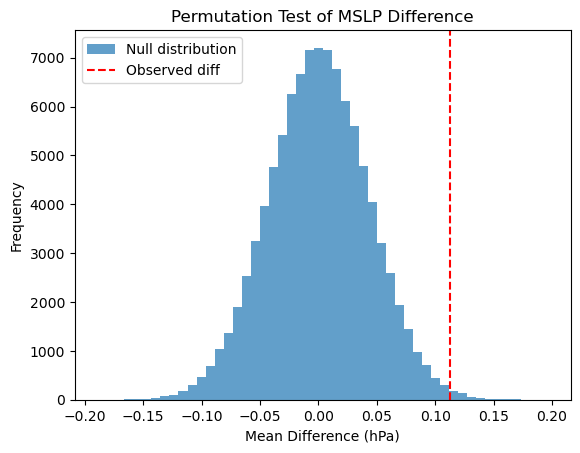

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# ens_idx_list = []
# for ens in ens_list:
#     if (target_time in ssv_dict[key_time][ens]):
#         ens_idx_list.append(ens)

# total_mslp_list = []
# for ens in ens_idx_list:
# # for ens in [1716, 2506]:
#     output_data_dir = f'{pangu_dir}/output_data/{first_str}/{perturation_scale}ENS{surface_str}{upper_str}/{ens}'
#     met = Met(output_data_dir, predict_interval, surface_dict, upper_dict, lat_start, lat_end, lon_start, lon_end, lat_grid, lon_grid, input_sign = 'n')

#     data = met.met_data('MSLP', level ='sf')


#     # 해면기압의 로컬 최소값의 위치 찾기
#     data_copy = np.copy(data)   #data_copy는 MSLP 정보
#     filtered_data = minimum_filter(data_copy, size = 20)
#     local_minima = data_copy == filtered_data
#     minima_labels, num_features = label(local_minima)
#     minima_positions = np.array([np.mean(np.where(minima_labels == i), axis=1) for i in range(1, num_features+1)])
#     minima_positions = minima_positions.astype(int)



#     # minima_positions가 정수형 인덱스 배열이라고 가정 (N, 2)
#     lon_vals = lon_grid[minima_positions[:, 0], minima_positions[:, 1]]
#     lat_vals = lat_grid[minima_positions[:, 0], minima_positions[:, 1]]

#     # 기준점 (150, 25)와의 거리 계산
#     target_lon, target_lat = 150, 25
#     distances = np.sqrt((lon_vals - target_lon)**2 + (lat_vals - target_lat)**2)

#     # 가장 가까운 index 선택
#     closest_idx = np.argmin(distances)
#     closest_pos = minima_positions[closest_idx]
#     closest_i, closest_j = closest_pos

#     # 정확한 위치의 MSLP 값 추출
#     closest_mslp = data[closest_i, closest_j]
#     total_mslp_list.append(closest_mslp)




# group_size = 50
# n_iterations = 10000


# # 실제 두 그룹 평균 차이
# observed_diff = np.abs(np.mean(mslp_group_list[0]) - np.mean(mslp_group_list[1]))

# # 모든 mslp를 통합
# combined = np.array(total_mslp_list)
# assert len(combined) == 2 * group_size

# # permutation test
# diffs = []
# for _ in range(n_iterations):
#     np.random.shuffle(combined)
#     group1 = combined[:group_size]
#     group2 = combined[group_size:]
#     diff = np.abs(np.mean(group1) - np.mean(group2))
#     diffs.append(diff)


group1 = np.array(mslp_group_list[0])
group2 = np.array(mslp_group_list[1])
combined = np.array(total_mslp_list)  # 예: 전체 4000 ensemble 멤버의 mslp

group_size = len(group1)
true_diff = np.mean(group1) - np.mean(group2)

n_permutations = 100000
diffs = []

for _ in range(n_permutations):
    sample = np.random.choice(combined, 2 * group_size, replace=False)
    fake1 = sample[:group_size]
    fake2 = sample[group_size:]
    diffs.append(np.mean(fake1) - np.mean(fake2))

diffs = np.array(diffs)
p_value = (np.abs(diffs) >= np.abs(true_diff)).mean()

print(f"실제 평균 차이: {true_diff:.3f}")
print(f"p-value: {p_value:.5f}")

# p-value: 실제 차이보다 큰 샘플 비율
diffs = np.array(diffs)
p_value = np.mean(diffs >= observed_diff)

# 결과 출력
print(f"Observed MSLP mean difference: {observed_diff:.2f} hPa")
print(f"P-value from permutation test: {p_value:.4f}")

# 시각화
plt.hist(diffs, bins=50, alpha=0.7, label='Null distribution')
plt.axvline(observed_diff, color='red', linestyle='--', label='Observed diff')
plt.xlabel('Mean Difference (hPa)')
plt.ylabel('Frequency')
plt.title('Permutation Test of MSLP Difference')
plt.legend()
plt.show()


### <span style="background:White; color:black; font-weight:bold">Maximum Convection Box🌧️ Vertical Profile</span>

슬라이딩 4x4 평균 최댓값 위치: (lat, lon) = (28, 150)
최댓값: 66.6329


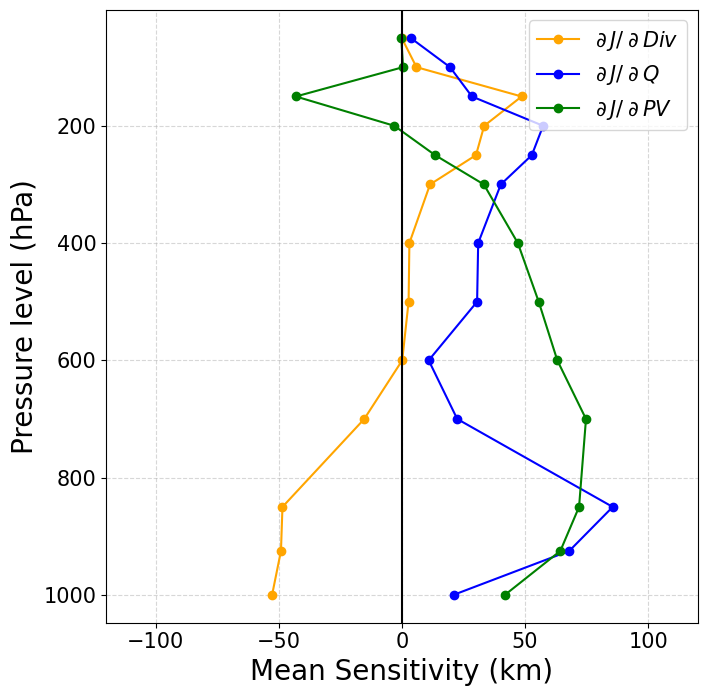

In [562]:


# cov_var: (161, 241) 예시
predict_interval = 24

tpw_cv = cov_var_dict[predict_interval]['tpw']
window = 13
mean_map = uniform_filter(tpw_cv, size=window, mode='constant')  # 가장자리는 0-padding

# 최대값 위치
max_idx = np.unravel_index(np.argmax(mean_map), mean_map.shape)
lat0, lon0 = lat_grid[max_idx[0], max_idx[1]], lon_grid[max_idx[0], max_idx[1]]   
lat0, lon0 = 28, 150

distance = np.sqrt((lon_grid - lon0)**2 + (lat_grid - lat0)**2)
max_idx = np.unravel_index(np.argmin(distance), distance.shape)


print(f"슬라이딩 4x4 평균 최댓값 위치: (lat, lon) = ({lat0}, {lon0})")
print(f"최댓값: {mean_map[max_idx]:.4f}")

div_cv_list = []
q_cv_list = []
pv_cv_list = []
for pres in level_list:
    div_cv = cov_var_dict[predict_interval]['div'][pres]
    q_cv = cov_var_dict[predict_interval]['q'][pres]
    pv_cv = cov_var_dict[predict_interval]['pv'][pres]

    div_cv_mean = np.mean(div_cv[max_idx[0] - window//2:max_idx[0] + window//2 + 1, max_idx[1] - window//2:max_idx[1] + window//2 + 1])
    q_cv_mean = np.mean(q_cv[max_idx[0] - window//2:max_idx[0] + window//2 + 1, max_idx[1] - window//2:max_idx[1] + window//2 + 1])
    pv_cv_mean = np.mean(pv_cv[max_idx[0] - window//2:max_idx[0] + window//2 + 1, max_idx[1] - window//2:max_idx[1] + window//2 + 1])
    div_cv_list.append(div_cv_mean)
    q_cv_list.append(q_cv_mean)
    pv_cv_list.append(pv_cv_mean)

plt.figure(figsize=(7, 7))

plt.plot(div_cv_list, level_list, label='$\partial \,J/\;\partial \,Div$', color='orange', marker='o')
plt.plot(q_cv_list, level_list, label='$\partial \,J/\;\partial \, Q$', color='blue', marker='o')
plt.plot(pv_cv_list, level_list, label='$\partial \,J/\;\partial \,PV$', color='green', marker='o')

# plt.plot(div_cv_list, level_list, label=r'$\frac{\partial \,J}{\partial \,Div}$', color='orange', marker='o')
# plt.plot(q_cv_list, level_list, label=r'$\frac{\partial \,J}{\partial \,Q}$', color='blue', marker='o')

FontProperties = fm.FontProperties(size=15, weight='black')
plt.gca().invert_yaxis()  # y축이 위가 낮고, 아래가 높도록 (pressure profile convention)
plt.axvline(0, color='black', linestyle='-')
plt.xlabel('Mean Sensitivity (km)', fontsize = 20)
plt.ylabel('Pressure level (hPa)', fontsize = 20)
plt.legend(loc='upper right', prop=FontProperties)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.xlim(-120,120)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.gca().invert_yaxis()
plt.show()

# ETC

## Position Correlation Analysis

Number of ensemble members: 12
False
Number of ensemble members: 31
False
Number of ensemble members: 385
False
Number of ensemble members: 1087
False
Number of ensemble members: 2652
False
Number of ensemble members: 3558
False
Number of ensemble members: 3806
False
Number of ensemble members: 3806
False
Number of ensemble members: 3806
False
Number of ensemble members: 3806
False
Number of ensemble members: 3806
False
Number of ensemble members: 3806
False
Number of ensemble members: 3806
False
Number of ensemble members: 3806
False
Number of ensemble members: 3806
False
Number of ensemble members: 3806
False
Number of ensemble members: 3806
True


/home1/jek/miniconda3/envs/pangu/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:652: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


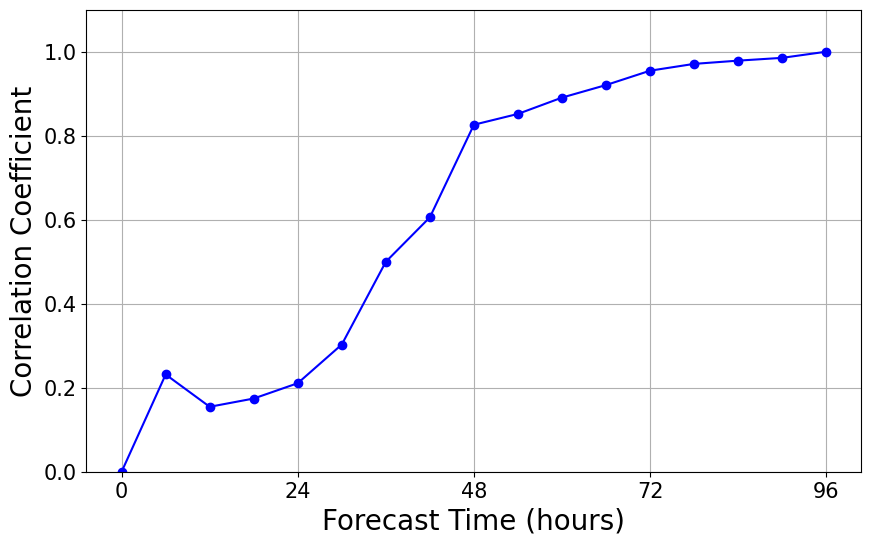

In [124]:
corr_list = []

for predict_interval in range(0, 97, 6):
    datetime1 = key_time + timedelta(hours=int(predict_interval))
    
    ens_idx_list = []
    cov_var_dict[predict_interval] = {}
        
    for ens in ens_list:
        if (target_time in ssv_dict[key_time][ens]) & (datetime1 in ssv_dict[key_time][ens]):
            ens_idx_list.append(ens)
    
    
    # 데이터를 추출합니다
    mid_pos = [(ssv_dict[key_time][ens][datetime1]['lon'], ssv_dict[key_time][ens][datetime1]['lat']) for ens in ens_idx_list]
    tar_pos = [(ssv_dict[key_time][ens][target_time]['lon'], ssv_dict[key_time][ens][target_time]['lat']) for ens in ens_idx_list]
    print(f'Number of ensemble members: {len(ens_idx_list)}')
    print(mid_pos == tar_pos)
    # NumPy 배열로 변환
    mid_pos, tar_pos = np.array(mid_pos), np.array(tar_pos)
    
    #타겟 위치의 PCA
    corr_pos_tar = np.copy(tar_pos)
    corr_pos_tar[:, 0] = (tar_pos[:, 0]-np.mean(tar_pos[:, 0])) * np.cos(np.radians(tar_pos[:, 1]))  # 경도에 cos(위도)를 곱해 거리 왜곡 보정
    pca_tar = PCA(n_components=1)
    pca_tar.fit(corr_pos_tar)
    pca_tar.mean_[0] = pca_tar.mean_[0] / np.cos(np.radians(pca_tar.mean_[1])) + np.mean(tar_pos[:, 0])
    ensemble_mean = np.mean(pca_tar.transform(corr_pos_tar)[:, 0])

    #distance 구하기
    corr_pos_tar = np.copy(tar_pos)
    corr_pos_tar[:, 0] = (tar_pos[:, 0]-np.mean(tar_pos[:, 0])) * np.cos(np.radians(tar_pos[:, 1]))  # 경도에 cos(위도)를 곱해 거리 왜곡 보정
    projection = pca_tar.transform(corr_pos_tar)[:, 0]  # 주축에 투영된 데이터 (1차원)

    distances_tar = (projection - ensemble_mean) * 111
    
    #타겟 위치의 PCA
    corr_pos_mid = np.copy(mid_pos)
    corr_pos_mid[:, 0] = (mid_pos[:, 0]-np.mean(mid_pos[:, 0])) * np.cos(np.radians(mid_pos[:, 1]))  # 경도에 cos(위도)를 곱해 거리 왜곡 보정
    pca_mid = PCA(n_components=1)
    pca_mid.fit(corr_pos_mid)
    pca_mid.mean_[0] = pca_mid.mean_[0] / np.cos(np.radians(pca_mid.mean_[1])) + np.mean(mid_pos[:, 0])
    ensemble_mean = np.mean(pca_mid.transform(corr_pos_mid)[:, 0])

    #distance 구하기
    corr_pos_mid = np.copy(mid_pos)
    corr_pos_mid[:, 0] = (mid_pos[:, 0]-np.mean(mid_pos[:, 0])) * np.cos(np.radians(mid_pos[:, 1]))  # 경도에 cos(위도)를 곱해 거리 왜곡 보정
    projection = pca_tar.transform(corr_pos_mid)[:, 0]  # 주축에 투영된 데이터 (1차원)

    distances_mid = (projection - ensemble_mean) * 111

    corr_list.append(np.abs(np.corrcoef(distances_mid, distances_tar)[0, 1]))


plt.figure(figsize=(10, 6))
plt.ylim(0,1.1)
plt.plot(range(0, 97, 6), np.abs(corr_list), marker='o', linestyle='-', color='b')
# plt.title(f'Correlation between Mid and Target Positions for {storm_name} ({key_str})')
plt.xlabel('Forecast Time (hours)', fontsize=20)
plt.ylabel('Correlation Coefficient', fontsize=20)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=15)
plt.xticks(range(0, 97, 24), fontsize=15)
plt.grid()

## Draw Deformation flow

100%|██████████| 3806/3806 [04:28<00:00, 14.20it/s]


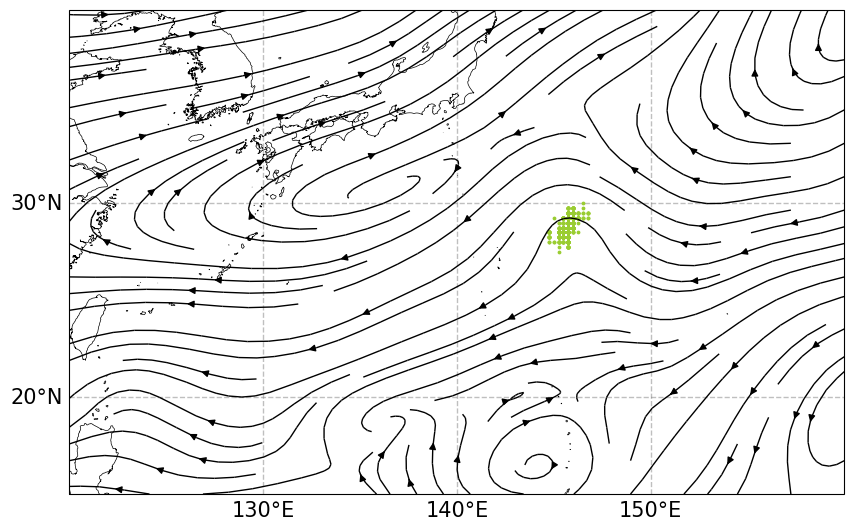

In [422]:

for predict_interval in range(48, 49, 24):
    datetime1 = key_time + timedelta(hours=int(predict_interval))
        
    ens_idx_list = []
    for ens in ens_list:
        if (target_time in ssv_dict[key_time][ens]):
            ens_idx_list.append(ens)

    u_output_list = []
    v_output_list = []

    for ens in tqdm(ens_idx_list):
        output_data_dir = f'{pangu_dir}/output_data/{first_str}/{perturation_scale}ENS{surface_str}{upper_str}/{ens}'
        met = Met(output_data_dir, predict_interval, surface_dict, upper_dict, lat_start, lat_end, lon_start, lon_end, lat_grid, lon_grid, input_sign = 'n')

        u_output = met.met_data('u', level ='500')
        v_output = met.met_data('v', level ='500')
        u_output_list.append(u_output)
        v_output_list.append(v_output)

    u_output_list = np.array(u_output_list)
    v_output_list = np.array(v_output_list)


    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': proj})
    # ax.set_extent(extent, crs=proj)
    ax.coastlines('10m', linewidth=0.5)
    ax.set_extent([120, 160, 15, 40], crs=proj)
    ax.streamplot(lon_grid, lat_grid, np.mean(u_output_list, axis = 0), np.mean(v_output_list, axis = 0), color='black', linewidth=1, transform=proj, density=1)
    map_gridlines(ax, proj = proj, font_size = 15)

    ens_idx_list = []
    for ens in ens_list:
        if (target_time in ssv_dict[key_time][ens]) and (datetime1 in ssv_dict[key_time][ens]):
            ens_idx_list.append(ens)

    mid_pos = np.array([(ssv_dict[key_time][ens][datetime1]['lon'], ssv_dict[key_time][ens][datetime1]['lat']) for ens in ens_idx_list])
    plt.scatter(mid_pos[:, 0], mid_pos[:, 1], c='yellowgreen', s=3, transform=proj)

    plt.show()

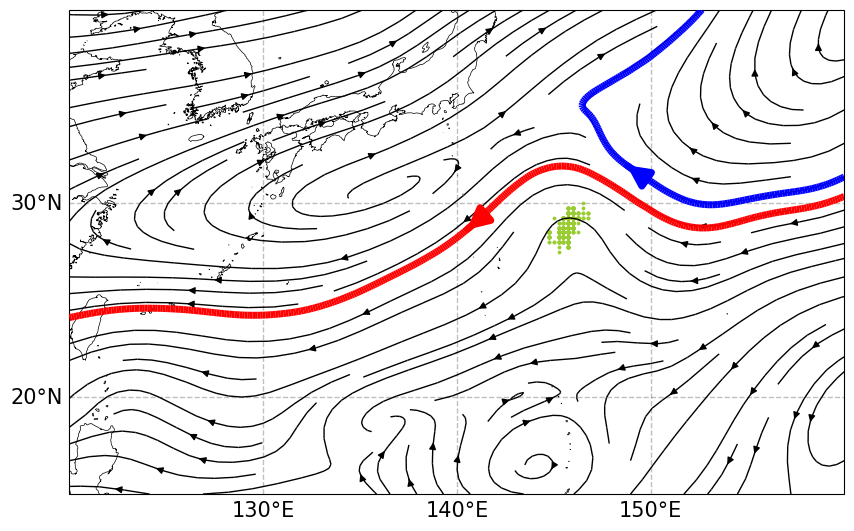

In [429]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': proj})
# ax.set_extent(extent, crs=proj)
ax.coastlines('10m', linewidth=0.5)
ax.set_extent([120, 160, 15, 40], crs=proj)
ax.streamplot(lon_grid, lat_grid, np.mean(u_output_list, axis = 0), np.mean(v_output_list, axis = 0), color='black', linewidth=1, transform=proj, density=1)
ax.streamplot(lon_grid, lat_grid, np.mean(u_output_list, axis = 0), np.mean(v_output_list, axis = 0),
          start_points=np.array([[150, 31.15]]), # 다른 시작점
          color='blue', linewidth=5, zorder=20,arrowsize=3,density=10,
          transform=ccrs.PlateCarree())
ax.streamplot(lon_grid, lat_grid, np.mean(u_output_list, axis = 0), np.mean(v_output_list, axis = 0),
          start_points=np.array([[150, 29.65]]), # 다른 시작점
          color='red', linewidth=5, zorder=20,arrowsize=3,density=10,
          transform=ccrs.PlateCarree())
map_gridlines(ax, proj = proj, font_size = 15)

ens_idx_list = []
for ens in ens_list:
    if (target_time in ssv_dict[key_time][ens]) and (datetime1 in ssv_dict[key_time][ens]):
        ens_idx_list.append(ens)

mid_pos = np.array([(ssv_dict[key_time][ens][datetime1]['lon'], ssv_dict[key_time][ens][datetime1]['lat']) for ens in ens_idx_list])
plt.scatter(mid_pos[:, 0], mid_pos[:, 1], c='yellowgreen', s=3, transform=proj)

plt.show()